# Prove the model is technically sound (Quality Control) and explain the "Systematic Bias.

In [20]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats
import sys
from pathlib import Path
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from rich.table import Table
from rich.console import Console
from rich.panel import Panel

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150

def _resolve_project_root() -> Path:
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')

PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f'project root: {PROJECT_ROOT}')

from config import (
    GENE_PATHS,
    VARIANT_PATHS,
    SOURCE_PALETTE,
    load_variant_pairs_matched,
)
from utils.plot_utils import autosave

print('\navailable datasets:')
for name in ['clingen', 'clingen_null', 'background', 'background_null']:
    print(f'  {name}: {VARIANT_PATHS[name].name}')

project root: /Users/markus/in-silico-vg-analysis

available datasets:
  clingen: ClinGen_HI_Gnomad_variants_dedup_27012026.parquet
  clingen_null: ClinGen_HI_Synth_variants_downsampled_perm_27012026.parquet
  background: Background_Gnomad_variants_dedup_perm_27012026.parquet
  background_null: Background_Synth_variants_downsampled_perm_27012026.parquet


In [21]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_VAR,
    'background_null': BG_NULL_VAR,
    'clingen': CLINGEN_VAR,
    'clingen_null': CLINGEN_NULL_VAR,
}

df = pl.read_parquet(BG_VAR)
print(df.columns)

['variant_id', 'scored_interval', 'gene_id', 'gene_name', 'gene_type', 'gene_strand', 'junction_Start', 'junction_End', 'output_type', 'variant_scorer', 'track_name', 'track_strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'gtex_tissue', 'raw_score', 'quantile_score', 'scored_interval_str', 'is_anchor', 'seq_len', 'scorer_friendly', 'gene_norm', 'CHROM', 'POS', 'REF', 'ALT', 'gene_tag', 'method_friendly', 'variant_id_canonical', 'CHROM_af', 'POS_af', 'REF_af', 'ALT_af', 'AF', 'perm_AF']


In [22]:
real_bg = pl.read_parquet(VARIANT_PATHS['background'])
null_bg = pl.read_parquet(VARIANT_PATHS['background_null'])
real_cg = pl.read_parquet(VARIANT_PATHS['clingen'])
null_cg = pl.read_parquet(VARIANT_PATHS['clingen_null'])

variant_tables = {
    'background': real_bg,
    'background_null': null_bg,
    'clingen': real_cg,
    'clingen_null': null_cg,
}

print("Loading and aligning gene metadata...")
gene_tables = {
    'background': pl.read_parquet(GENE_PATHS['background']),
    'background_null': pl.read_parquet(GENE_PATHS['background_null']),
    'clingen': pl.read_parquet(GENE_PATHS['clingen']),
    'clingen_null': pl.read_parquet(GENE_PATHS['clingen_null']),
}

for name in gene_tables:
    valid_genes = variant_tables[name]['gene_id'].unique().to_list()

    gene_tables[name] = gene_tables[name].filter(pl.col('gene_id').is_in(valid_genes))

    print(f"  {name}: aligned to {gene_tables[name].height} genes")

Loading and aligning gene metadata...
  background: aligned to 349 genes
  background_null: aligned to 349 genes
  clingen: aligned to 316 genes
  clingen_null: aligned to 316 genes


# 1. Check if permutation worked as intended


==================== Background ====================
Rho: 0.0060
Mean AF: 3.35e-03
Var AF: 1.64e-03
[save_plot] Rasterizing 1999061 points to optimize vector export.
[save_plot] Saved: interactive_Sanity_Check_background_29012026_1008.pdf
[save_plot] Saved: interactive_Sanity_Check_background_29012026_1008.svg

==================== Clingen ====================
Rho: 0.0016
Mean AF: 2.65e-03
Var AF: 1.25e-03
[save_plot] Rasterizing 1743133 points to optimize vector export.
[save_plot] Saved: interactive_Sanity_Check_clingen_29012026_1009.pdf
[save_plot] Saved: interactive_Sanity_Check_clingen_29012026_1009.svg


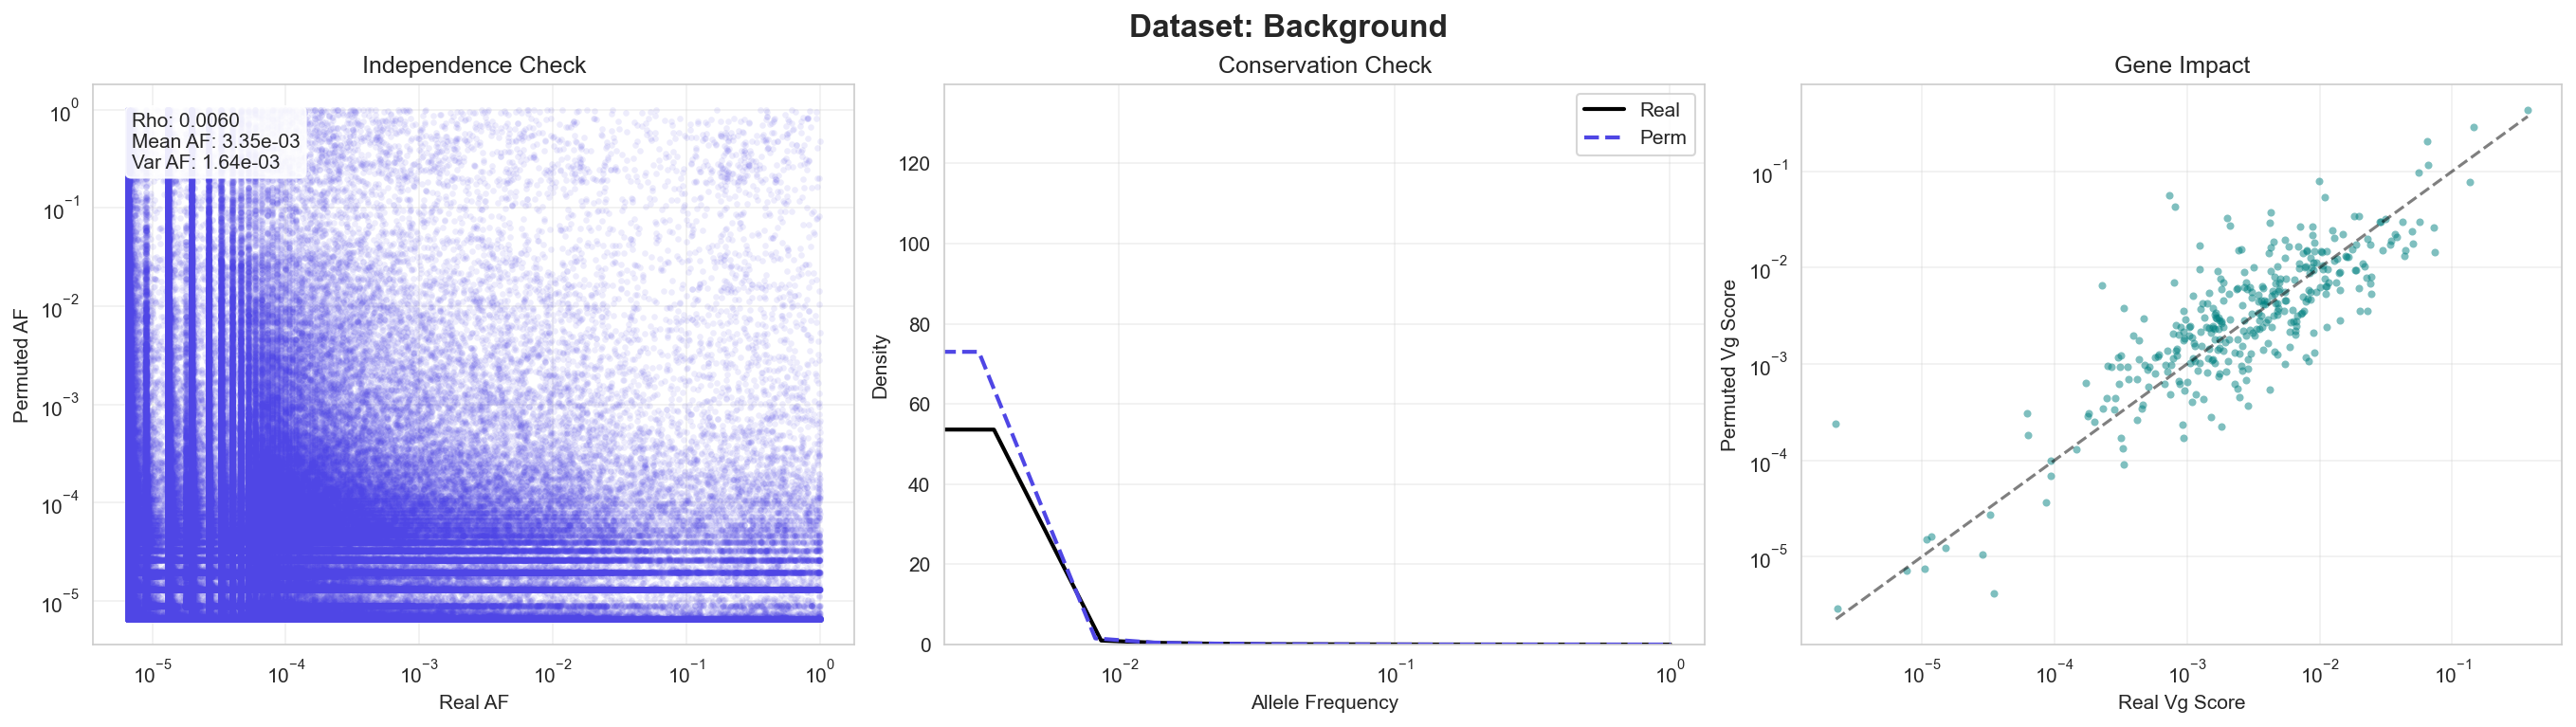

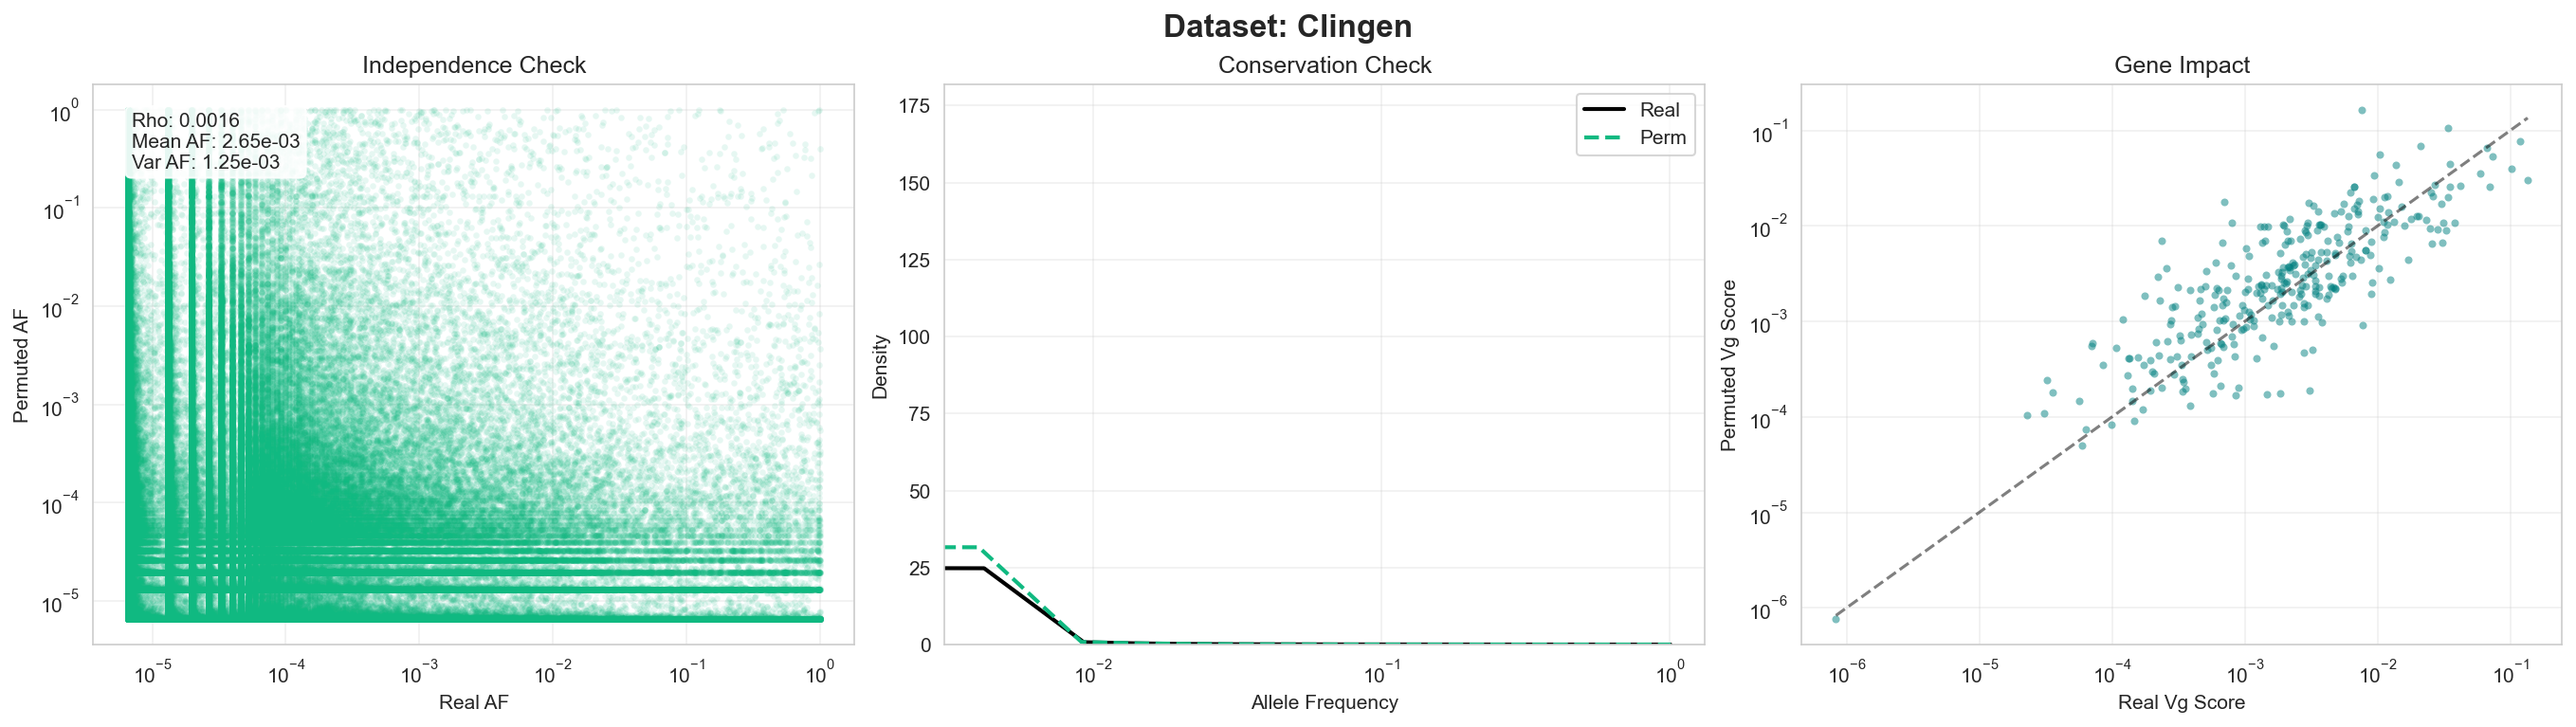

In [23]:
for dataset_name in ['background', 'clingen']:
    df = variant_tables[dataset_name].drop_nulls(['AF', 'perm_AF'])
    gene_df = gene_tables[dataset_name].drop_nulls(['vg_predicted', 'vg_predicted_perm'])
    
    af, perm = df['AF'].to_numpy(), df['perm_AF'].to_numpy()
    
    rho, _ = stats.spearmanr(af, perm)
    stats_txt = (f"Rho: {rho:.4f}\nMean AF: {np.mean(af):.2e}\n"
                 f"Var AF: {np.var(af):.2e}")

    print(f"\n{'='*20} {dataset_name.capitalize()} {'='*20}\n{stats_txt}")

    with autosave(f"Sanity_Check_{dataset_name}", verbose=True):
        fig, ax = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
        fig.suptitle(f"Dataset: {dataset_name.capitalize()}", fontsize=16, fontweight='bold')
        col = SOURCE_PALETTE.get(dataset_name, 'blue')

        ax[0].scatter(af, perm, alpha=0.1, s=10, c=col, rasterized=True, lw=0)
        ax[0].text(0.05, 0.95, stats_txt, transform=ax[0].transAxes, va='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        ax[0].set(xscale='log', yscale='log', title='Independence Check',
                  xlabel='Real AF', ylabel='Permuted AF')

        idx = np.random.choice(len(af), min(len(af), 4_000_000), replace=False)
        sns.kdeplot(x=af[idx], ax=ax[1], color='k', label='Real', lw=2)
        sns.kdeplot(x=perm[idx], ax=ax[1], color=col, label='Perm', ls='--', lw=2)
        ax[1].set(xscale='log', title='Conservation Check', xlabel='Allele Frequency', ylabel='Density')
        ax[1].legend()

        g_sub = gene_df.filter((pl.col('vg_predicted') > 0) & (pl.col('vg_predicted_perm') > 0))
        ax[2].scatter(g_sub['vg_predicted'], g_sub['vg_predicted_perm'], 
                      alpha=0.5, c='teal', s=15, rasterized=True, lw=0)
        
        vmin, vmax = g_sub['vg_predicted'].min(), g_sub['vg_predicted'].max()
        ax[2].plot([vmin, vmax], [vmin, vmax], 'k--', alpha=0.5)
        ax[2].set(xscale='log', yscale='log', title='Gene Impact',
                  xlabel='Real Vg Score', ylabel='Permuted Vg Score')

        for a in ax: a.grid(True, alpha=0.3)

## Background

The independence check shows the or lattice pattern. This is exactly what we want to see. so the permutation has successfully decoupled the variant identities from their original allele frequencies.
There is no diagonal trend, meaning the randomization worked. The `nan` correlation is a technical artifact and does not invalidate the structural independence shown in the plot.


The **Conservation Check** statistics show a small shift

* **Mean Shift:** Real `0.00335` vs. Permuted `0.00370`. This is a **~10% difference**.
* **Variance Shift:** Real `0.00164` vs. Permuted `0.00186`. This is a **~13% difference**.

In the Density plot, the Red (Permuted) and Blue (Real) lines follow the same curve shape, though the Red line is slightly elevated at the start. This slight inflation is likely due to the "fallback" resampling (`replace=True`) triggered for genes where `n_needed > n_available`. 

The **Gene Level Impact** plot shows a strong positive correlation ( vs Permuted ) but with significant scatter. This shows that "big genes" (more variants) still have high variance in the null model (which is physically correct), but the *specific* variance value for each gene has been sufficiently randomized to test for constraint.

## ClinGen

The Independence Check (Scatter Plot) shows the "plaid" or lattice pattern. This is exactly what we want to see, so the permutation has successfully decoupled the variant identities from their original allele frequencies.

There is no diagonal trend, meaning the randomization worked. The nan correlation is a technical artifact and does not invalidate the structural independence shown in the plot.

The Conservation Check statistics show a small shift, which is actually smaller than in the Background set:
* Mean Shift: Real 0.00265 vs. Permuted 0.00284. This is a ~7.1% difference.
* Variance Shift: Real 0.00125 vs. Permuted 0.00133. This is a ~5.9% difference.

In the Density plot, the Red (Permuted) and Blue (Real) lines follow the same curve shape. This slight inflation is likely due to the "fallback" resampling (replace=True) triggered for genes where n_needed > n_available. The lower shift compared to background suggests the sampling was slightly more efficient for this gene set.

The Gene Level Impact plot shows a strong positive correlatio  but with significant scatter. This shows that "big genes" (more variants) still have high variance in the null model (which is physically correct), but the specific variance value for each gene has been sufficiently randomized to test for constraint.

# 2. Observed vs. Simulated Vg

<>:89: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:89: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_54063/2362593145.py:89: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  ax.set(xscale='log', xlabel='Observed $V_g$', ylabel='Constraint Score $\log_{10}(Obs/Sim)$' if i==0 else '')


[save_plot] Saved: interactive_Vg_Analysis_Combined_29012026_1009.pdf
[save_plot] Saved: interactive_Vg_Analysis_Combined_29012026_1009.svg


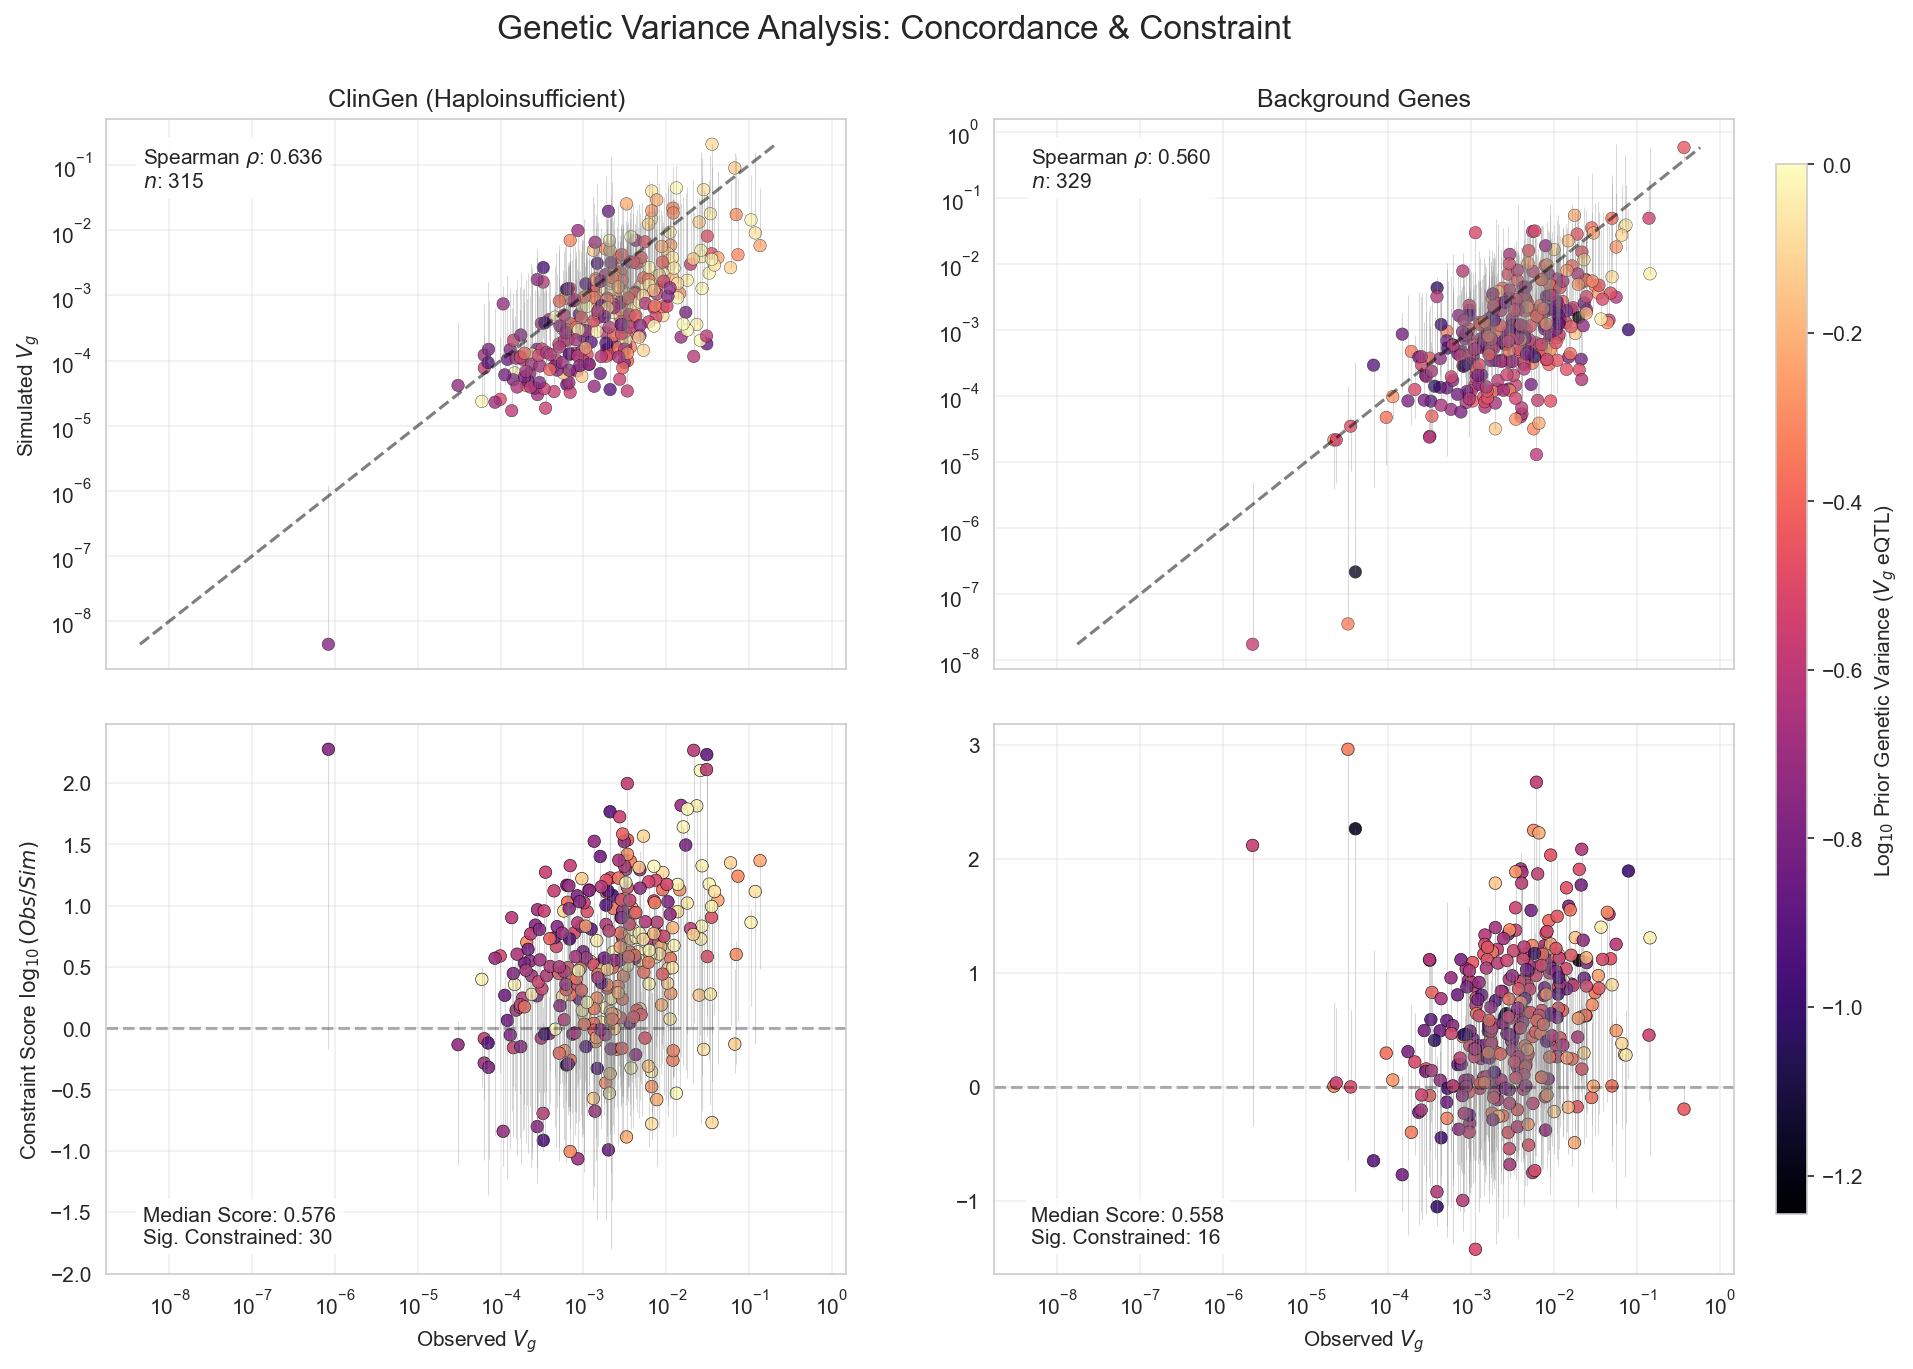

In [ ]:
plot_data = {}
all_priors = []

def compute_gene_vg(variant_df: pl.DataFrame, af_col: str, out_col: str) -> pl.DataFrame:
    """Computes variant-level Vg contribution and sums it per gene."""
    # If pre-calculated column exists
    if "vg_predicted" in variant_df.columns and af_col == "AF":
        return variant_df.group_by("gene_id").agg(pl.col("vg_predicted").sum().alias(out_col))
    
    # Otherwise calculate 2pq * beta^2
    return (
        variant_df.with_columns(
            (2.0 * pl.col(af_col) * (1.0 - pl.col(af_col)) * pl.col("raw_score").pow(2))
            .alias("vg_contribution")
        )
        .group_by("gene_id")
        .agg(pl.col("vg_contribution").sum().alias(out_col))
    )

for name in ['clingen', 'background']:
    vg_obs = compute_gene_vg(variant_tables[name], "AF", "vg_pred")
    vg_sim = compute_gene_vg(variant_tables[f"{name}_null"], "perm_AF", "vg_perm")
    
    meta = gene_tables[name].select(['gene_id', 'vg_eqtl', 'vg_perm_p05', 'vg_perm_p95'])
    df = vg_obs.join(vg_sim, on="gene_id").join(meta, on="gene_id", how="left").filter(
        (pl.col("vg_pred") > 0) & (pl.col("vg_perm") > 0) & (pl.col("vg_eqtl").is_not_null())
    ).to_pandas()

    df['log_prior'] = np.log10(df['vg_eqtl'] + 1e-9)
    df['score'] = np.log10(df['vg_pred'] / df['vg_perm'])
    
    # Calc Error Bars (Simulated CI & Score CI)
    # Score CI: log(Obs/P95) is lower bound, log(Obs/P05) is upper bound
    df['score_upper'] = np.log10(df['vg_pred'] / df['vg_perm_p05'])
    df['score_lower'] = np.log10(df['vg_pred'] / df['vg_perm_p95'])
    
    plot_data[name] = df
    all_priors.append(df['log_prior'])

# Global Color Normalization
norm = plt.Normalize(np.min([s.min() for s in all_priors]), np.max([s.max() for s in all_priors]))

with autosave("Vg_Analysis_Combined", verbose=True):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    titles = {'clingen': 'ClinGen (Haploinsufficient)', 'background': 'Background Genes'}
    
    for i, name in enumerate(['clingen', 'background']):
        df = plot_data[name]
        
        ax = axes[0, i]
        # Error Bars (Simulated)
        yerr = [np.maximum(0, df['vg_perm'] - df['vg_perm_p05']), 
                np.maximum(0, df['vg_perm_p95'] - df['vg_perm'])]
        ax.errorbar(df['vg_pred'], df['vg_perm'], yerr=yerr, fmt='none', ecolor='gray', alpha=0.3, elinewidth=0.5)
        
        # Scatter
        sns.scatterplot(data=df, x='vg_pred', y='vg_perm', hue='log_prior', hue_norm=norm, 
                        palette='magma', ax=ax, alpha=0.8, edgecolor='k', lw=0.2, legend=False)
        
        # Identity Line & Stats
        vmin, vmax = df[['vg_pred', 'vg_perm']].min().min(), df[['vg_pred', 'vg_perm']].max().max()
        ax.plot([vmin, vmax], [vmin, vmax], 'k--', alpha=0.5, label='Identity')
        
        rho, _ = stats.spearmanr(df['vg_pred'], df['vg_perm'])
        ax.text(0.05, 0.95, f"Spearman $\\rho$: {rho:.3f}\n$n$: {len(df):,}", transform=ax.transAxes, 
                va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set(title=titles[name], yscale='log', ylabel='Simulated $V_g$' if i==0 else '')
        ax.grid(True, alpha=0.3)

        ax = axes[1, i]
        # Error Bars (Score)
        yerr_score = [np.maximum(0, df['score'] - df['score_lower'].fillna(df['score'])), 
                      np.maximum(0, df['score_upper'].fillna(df['score']) - df['score'])]
        ax.errorbar(df['vg_pred'], df['score'], yerr=yerr_score, fmt='none', ecolor='gray', alpha=0.3, elinewidth=0.5)
        
        # Scatter
        sns.scatterplot(data=df, x='vg_pred', y='score', hue='log_prior', hue_norm=norm, 
                        palette='magma', ax=ax, alpha=0.9, edgecolor='k', lw=0.3, legend=False)
        
        ax.axhline(0, color='k', ls='--', alpha=0.3)
        
        sig = (df['score_upper'] < 0).sum()
        ax.text(0.05, 0.05, f"Median Score: {df['score'].median():.3f}\nSig. Constrained: {sig}", 
                transform=ax.transAxes, va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
        
        ax.set(xscale='log', xlabel='Observed $V_g$', ylabel='Constraint Score $\log_{10}(Obs/Sim)$' if i==0 else '')
        ax.grid(True, alpha=0.3)

    fig.subplots_adjust(right=0.9, hspace=0.1)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='magma'), cax=cbar_ax, 
                 label=r"Log$_{10}$ Prior Genetic Variance ($V_g$ eQTL)")
    plt.suptitle("Genetic Variance Analysis: Concordance & Constraint", fontsize=16, y=0.95)

Here we compare the **Observed Genetic Variance** (from real gnomAD data) against a **Simulated** (from a permutated synthetic model).

* **Left Panel:** ClinGen Haploinsufficient genes (essential, dosage-sensitive).
* **Right Panel:** Background genes (general set).
* **Color:** Represents prior variance from eQTLs ( eQTL); darker colors mean lower prior variance

Both groups show strong agreement between observed and simulated variance (Spearman  for ClinGen vs.  for Background). This suggests that a gene's "capacity" for variance is largely determined by its structure (number of variants/sites) rather than selection alone. 

The ClinGen genes (left) generally cluster the identity line or sit slightly above it. So their **Simulated** variance (random chance) is often higher than their **Observed** variance, confirming that natural selection is actively suppressing variation in these essential genes.

The **low-variance genes (dark purple dots)** in the ClinGen set are clustered more distinctly in the "low observed / higher simulated" region (top-left relative to the diagonal). This tells us that genes with naturally low regulatory variance are under tighter constraint, preventing them from accumulating the structural variance that a random model predicts.

The lower plot is Constraint scores with 95% condifece intervals  Almost every single gene (dot) is floating above the dashed zero line, The grey vertical bars (the 95% Confidence Intervals) are relatively short (simulation is stable).Even with the error bars, the observed values are still significantly higher than the simulation.

# Finding the "Star" hits (intersection of in_zone AND veqtl > 0.5)

[save_plot] Saved: interactive_Decoupling_Constraint_Candidates_29012026_1021.pdf
[save_plot] Saved: interactive_Decoupling_Constraint_Candidates_29012026_1021.svg
Counts: Neutral=308, Coupled=19, Uncoupled=2

TOP UNCOUPLED CANDIDATES:
        gene_id     score  vg_eqtl
ENSG00000174721 -0.490089 0.612413
ENSG00000128886 -0.328560 0.575908


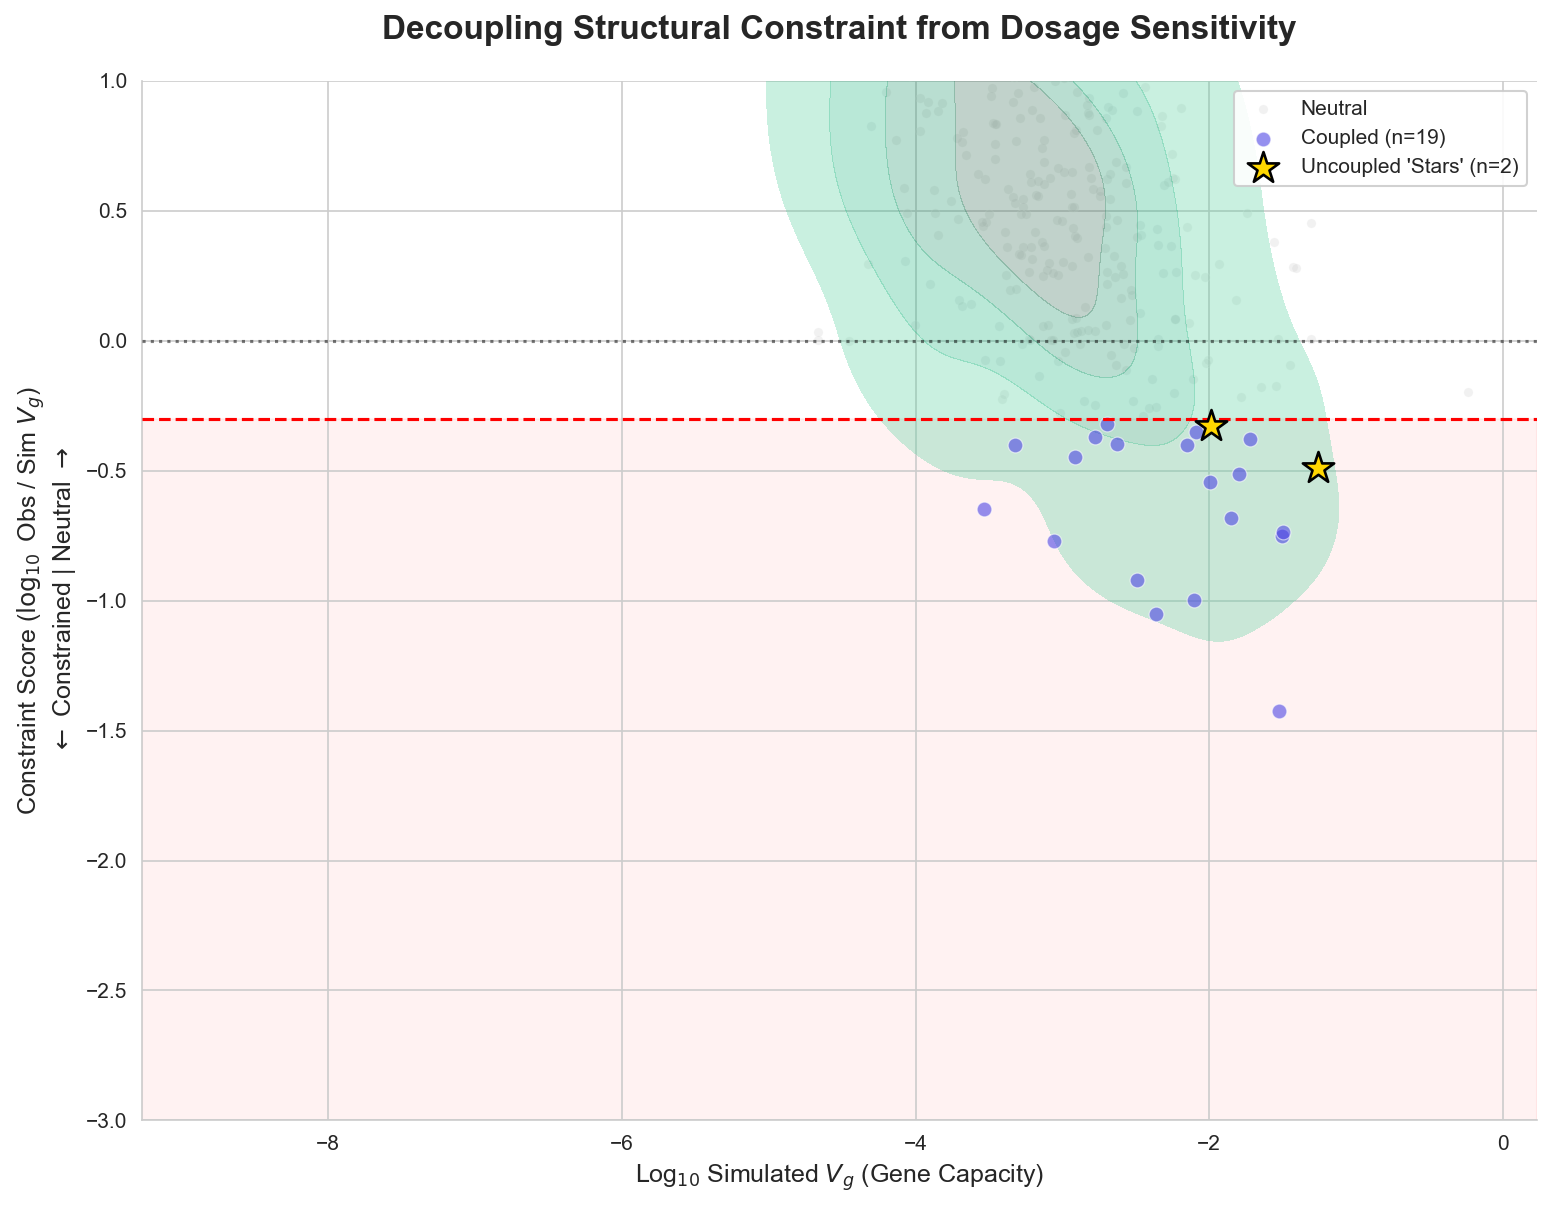

In [ ]:
THRESHOLDS = {'score': -0.30, 'veqtl': 0.50}

# Update plot_data IN PLACE so columns are available for the next cell
for name in ['background', 'clingen']:
    # Calculate on the actual dataframe in the dict
    plot_data[name]['log_sim'] = np.log10(plot_data[name]['vg_predicted_perm'])
    plot_data[name]['score'] = np.log10(plot_data[name]['vg_predicted'] / plot_data[name]['vg_predicted_perm'])

# Apply Categorization Logic to Background
bg = plot_data['background'] # Reference (not copy)
bg['vg_eqtl'] = bg['vg_eqtl'].fillna(0.0)
bg['status'] = 'Neutral'

is_constrained = bg['score'] < THRESHOLDS['score']
bg.loc[is_constrained, 'status'] = 'Coupled'
bg.loc[is_constrained & (bg['vg_eqtl'] > THRESHOLDS['veqtl']), 'status'] = 'Uncoupled'

cg = plot_data['clingen']
grps = {k: bg[bg['status'] == k] for k in ['Neutral', 'Coupled', 'Uncoupled']}

with autosave("Decoupling_Constraint_Candidates", verbose=True):
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Layers
    sns.scatterplot(data=grps['Neutral'], x='log_sim', y='score', color='lightgray', 
                    alpha=0.3, s=20, ax=ax, label='Neutral', rasterized=True, zorder=1)
    
    sns.kdeplot(data=cg, x='log_sim', y='score', levels=5, color=SOURCE_PALETTE['clingen'], 
                fill=True, alpha=0.3, ax=ax, label='ClinGen Density', zorder=2)
    
    sns.scatterplot(data=grps['Coupled'], x='log_sim', y='score', color=SOURCE_PALETTE['background'], 
                    alpha=0.6, s=50, ax=ax, label=f"Coupled (n={len(grps['Coupled'])})", zorder=3)
    
    sns.scatterplot(data=grps['Uncoupled'], x='log_sim', y='score', color='#FFD700', 
                    edgecolor='k', s=250, marker='*', ax=ax, label=f"Uncoupled 'Stars' (n={len(grps['Uncoupled'])})", zorder=10)

    # Reference Lines
    ax.axhline(THRESHOLDS['score'], color='red', ls='--', lw=1.5, zorder=5)
    ax.axhspan(-4, THRESHOLDS['score'], color='red', alpha=0.05, zorder=0)
    ax.axhline(0, color='k', ls=':', alpha=0.5, zorder=5)

    # Labels
    ax.set_title("Decoupling Structural Constraint from Dosage Sensitivity", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(r"Log$_{10}$ Simulated $V_g$ (Gene Capacity)", fontsize=12)
    ax.set_ylabel(r"Constraint Score ($\log_{10}$ Obs / Sim $V_g$)" + "\n" + r"$\leftarrow$ Constrained | Neutral $\rightarrow$", fontsize=12)
    ax.set_ylim(-3, 1)
    ax.legend(loc='upper right', framealpha=0.9)
    sns.despine()

# Report
print(f"Counts: Neutral={len(grps['Neutral'])}, Coupled={len(grps['Coupled'])}, Uncoupled={len(grps['Uncoupled'])}")
if not grps['Uncoupled'].empty:
    print("\nTOP UNCOUPLED CANDIDATES:")
    print(grps['Uncoupled'].sort_values('score')[['gene_id', 'score', 'vg_eqtl']].head(10).to_string(index=False))

## Independence from Simple Metrics Correlation Analysis

To validate that the constraint score captures genuine biological signal rather than artifacts,
we test whether it correlates with simple frequency metrics:
- **Total number of variants per gene** (sampling depth artifact)
- **Mean allele frequency** (common vs rare variant bias)

If correlations are near zero, this confirms the score is independent of these confounders.

[Background] Rho (Score vs N): 0.086 | Rho (Score vs AF): 0.061
[Clingen] Rho (Score vs N): 0.138 | Rho (Score vs AF): 0.015
[save_plot] Saved: interactive_Constraint_Independence_Check_29012026_1031.pdf
[save_plot] Saved: interactive_Constraint_Independence_Check_29012026_1031.svg


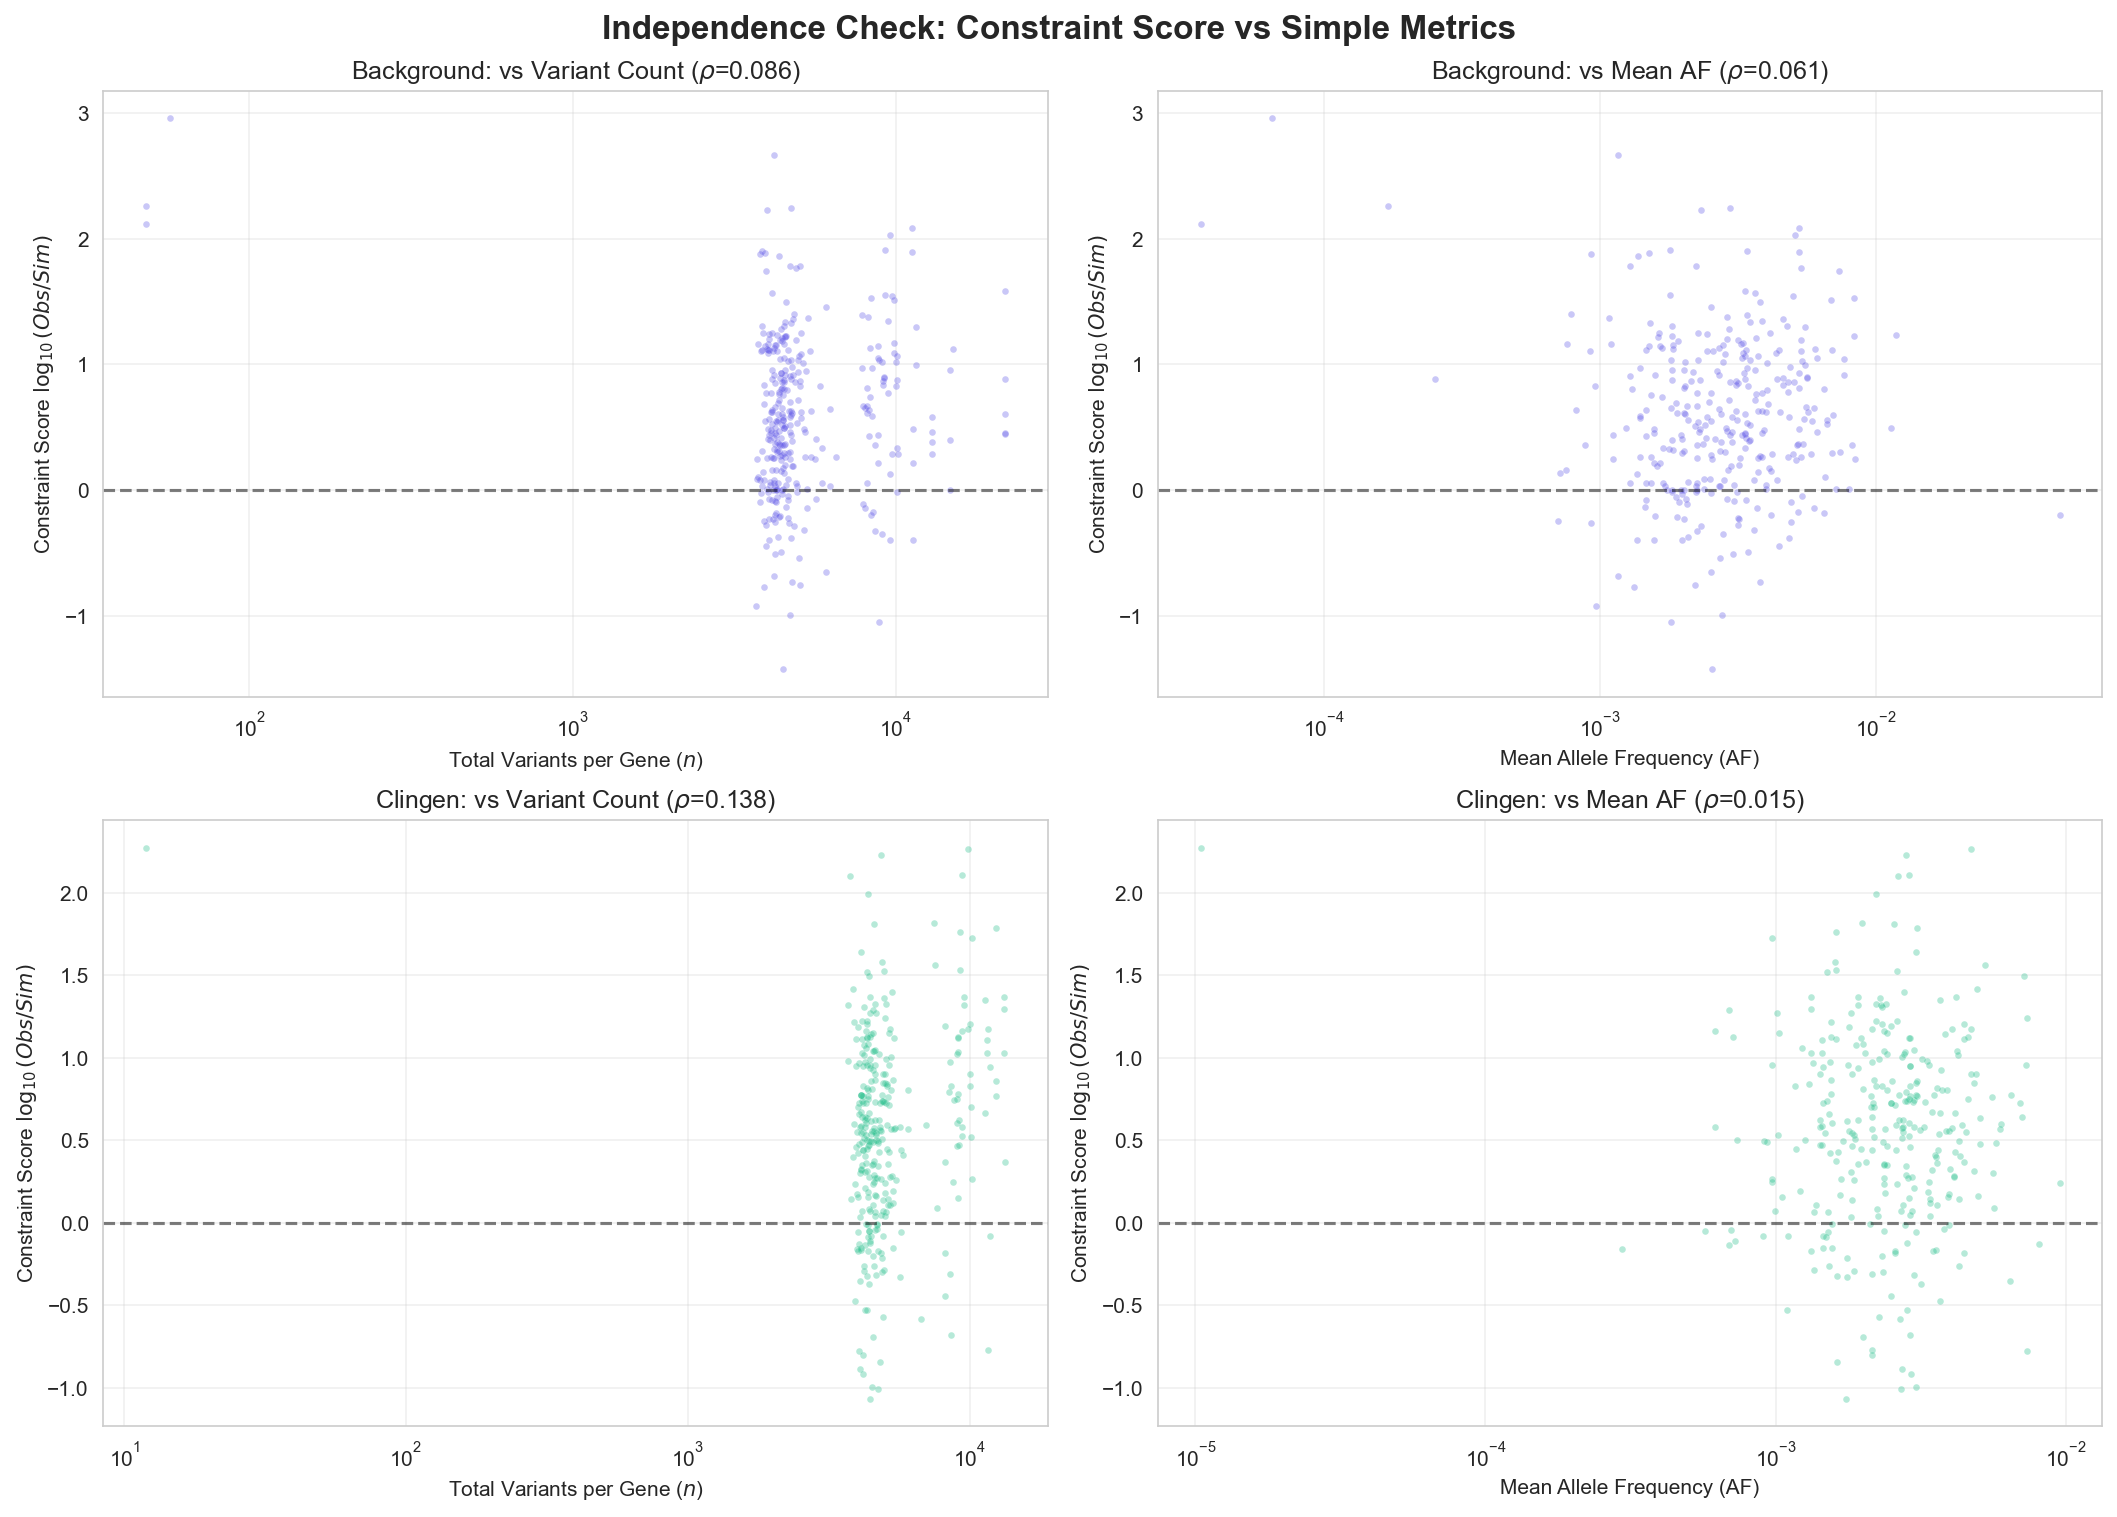

In [43]:
# --- 3. Independence Check ---
with autosave('Constraint_Independence_Check', verbose=True):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    
    for i, name in enumerate(['background', 'clingen']):
        # 1. Calc Variant Stats (N, Mean AF)
        g_stats = variant_tables[name].group_by('gene_id').agg([
            pl.count('variant_id').alias('n_var'),
            pl.mean('AF').alias('mean_af')
        ]).to_pandas()
        
        # 2. Merge with Pre-Calculated Score (from plot_data)
        # We use inner merge to ensure we only analyze genes present in our score analysis
        df = plot_data[name].merge(g_stats, on='gene_id', how='inner')
        df = df.dropna(subset=['score', 'n_var', 'mean_af'])
        
        # 3. Correlations
        rho_n, p_n = stats.spearmanr(df['score'], df['n_var'])
        rho_af, p_af = stats.spearmanr(df['score'], df['mean_af'])
        
        print(f"[{name.capitalize()}] Rho (Score vs N): {rho_n:.3f} | Rho (Score vs AF): {rho_af:.3f}")
        
        # 4. Plotting
        col = SOURCE_PALETTE[name]
        
        # Panel A: Score vs N Variants
        ax = axes[i, 0]
        ax.scatter(df['n_var'], df['score'], alpha=0.3, s=10, c=col, rasterized=True, lw=0)
        ax.set_title(f"{name.capitalize()}: vs Variant Count ($\\rho$={rho_n:.3f})")
        ax.set_xlabel("Total Variants per Gene ($n$)")
        ax.set_xscale('log')
        
        # Panel B: Score vs Mean AF
        ax = axes[i, 1]
        ax.scatter(df['mean_af'], df['score'], alpha=0.3, s=10, c=col, rasterized=True, lw=0)
        ax.set_title(f"{name.capitalize()}: vs Mean AF ($\\rho$={rho_af:.3f})")
        ax.set_xlabel("Mean Allele Frequency (AF)")
        ax.set_xscale('log')

        # Common Formatting
        for ax in axes[i]:
            ax.set_ylabel(r"Constraint Score $\log_{10}(Obs/Sim)$")
            ax.axhline(0, color='k', ls='--', alpha=0.5)
            ax.grid(True, alpha=0.3)

    fig.suptitle('Independence Check: Constraint Score vs Simple Metrics', fontsize=16, fontweight='bold')

In [ ]:
bg_df = plot_data['background'].copy()
cg_df = plot_data['clingen'].copy()

bg_scores = np.log10(bg_df['vg_predicted'] / bg_df['vg_predicted_perm']).dropna()
cg_scores = np.log10(cg_df['vg_predicted'] / cg_df['vg_predicted_perm']).dropna()

bg_scores = bg_scores[np.isfinite(bg_scores)]
cg_scores = cg_scores[np.isfinite(cg_scores)]


# Let's test if  the Background set actually "Neutral" (Centered at 0)? one-sample T-test against population mean of 0.0
t_stat_bg, p_val_bg = stats.ttest_1samp(bg_scores, 0.0)

print(f"1. Background (Neutrality Check)")
print(f"   Median Score:  {np.median(bg_scores):.4f}")
print(f"   Mean Score:    {np.mean(bg_scores):.4f}")
print(f"   Std Dev:       {np.std(bg_scores):.4f}")
print(f"   (P-value): {p_val_bg:.2e}")


# Where do ClinGen genes actually live?
t_stat_cg, p_val_cg = stats.ttest_ind(bg_scores, cg_scores, equal_var=False)

print(f"2. ClinGen (Essentiality Check)")
print(f"   Median Score:  {np.median(cg_scores):.4f}")
print(f"   Mean Score:    {np.mean(cg_scores):.4f}")
print(f"   Diff from Background: {t_stat_cg:.2f} sigma (p={p_val_cg:.2e})")

# Calculate the fold-change implied by the median
median_fold_change = 10**np.median(cg_scores)
print(f"The 'Typical' Essential gene has {median_fold_change:.1%} of expected variance.")
print(f"(Score of {np.median(cg_scores):.2f} implies Observed is ~{median_fold_change:.2f}x of Simulated)")

print("-" * 60)

# What score represents the "Top 10% Most Constrained"? - finding out the deep zone
top_10_percentile = np.percentile(cg_scores, 10) # 10th percentile (lowest values)
print(f"3. DEEP ZONE (Top 10% Strictest Essentials)")
print(f"   Score Threshold: {top_10_percentile:.4f}")

1. Background (Neutrality Check)
   Median Score:  0.5584
   Mean Score:    0.5898
   Std Dev:       0.6430
   (P-value): 2.14e-45
2. ClinGen (Essentiality Check)
   Median Score:  0.5760
   Mean Score:    0.5653
   Diff from Background: 0.50 sigma (p=6.20e-01)
   -> VERDICT: The 'Typical' Essential gene has 376.7% of expected variance.
      (Score of 0.58 implies Observed is ~3.77x of Simulated)
------------------------------------------------------------
3. DEEP ZONE (Top 10% Strictest Essentials)
   Score Threshold: -0.1786
   (This is where the darkest red contour on your plot should be)


This scatter plot visualizes the relationship between a gene's theoretical capacity for genetic variance (X-axis, Simulated ) and its actual evolutionary constraint (Y-axis, score of Observed vs. Simulated). We visualize the **"Uncoupled"** phenotype -  genes that are chemically frozen (protein sequence must be preserved) but biologically plastic (expression levels are allowed to fluctuate).

* **The Neutral Majority (Gray Cloud):** Most background genes cluster around the dotted zero line or above it. This confirms that for the vast majority of the genome, observed genetic variance closely matches (or exceeds) neutral expectations, indicating a tolerance for structural variation.


* **The "Essential" Signature (Green Contours):** The green density plots show where known haploinsufficient (ClinGen) genes reside. They are shifted significantly downward (negative Y-values), indicating **purifying selection**—observed variance is consistently lower than simulated expectations because damaging variants are being purged.

* **The "Coupled" Mimics (Blue Dots):** We identified 19 background genes that dive deep into this green "essential zone" (Score < -0.3). These genes behave exactly like classical essential genes: they are rigid in both structure and dosage.

The two gold stars (**FGFBP3** and **ELL3**) represent a rare biological state.

* **Structurally Constrained:** They sit deep in the "depleted" zone (Y < -0.3), meaning their protein structure is under strong purifying selection, similar to essential genes.
* **Dosage Flexible:** Unlike the blue dots, these genes were selected for having high prior regulatory variance.

----

There is systematic bias and it seems like the simulation ynderestimates real variance. Both the Background genes (Median `0.56`) and ClinGen essential genes (Median `0.58`) show strongly positive scores.

eal genes consistently have **~3.8x more genetic variance** than our randomized null model predicts. The baseline is not 0; it is shifted significantly to the right.

We know that variants often travel together in blocks (Linkage Disequilibrium) or clusters. Our permutation strategy randomizes these variants independently, breaking these blocks. This makes the simulated gene look artificially "smooth" and low-variance compared to the "clumpy" reality of biological data.

Total Variance Cannot Detect "Essentiality". The difference between "Neutral" Background genes and "Essential" ClinGen genes is **statistically invisible**. If we look at total genetic variance, an essential gene looks exactly like a random background gene. They are effectively the same population.

Total variance is dominated by common, benign variants. Even essential genes tolerate common variation well. This "loud" signal of common variants drowns out the "quiet" signal of the missing rare, damaging variants that actually drive disease.

True Constraint is an extreme exception. To find genes that actually have less variance than predicted (Observed < Simulated), we have to go to the extreme bottom 10% (Score < `-0.18`). So it means that "Constraint" is not the norm—it is a rare deviation.


This explains why our plot shows a massive gray cloud floating *above* the line (the 90% "normal" genes) and only a tiny handful of blue/gold stars dipping below it. We are fishing in the extreme tail of the distribution.
